In [1]:
import pandas as pd
import re
import json
from typing import List, Dict, Optional
import os
import pdfplumber

# Configuration
PDF_PATH = "/Users/sharadmishra/Desktop/codes_and_other/new_codes/newcodes/LangGraph_codes/Trade-Notice-RAG/data/raw/Trade_Notice_First_50_Pages.pdf" 
OUTPUT_JSON_PATH = "/Users/sharadmishra/Desktop/codes_and_other/new_codes/newcodes/LangGraph_codes/Trade-Notice-RAG/data/processed/hsn_structured_data.json"

print("Libraries loaded successfully.")

Libraries loaded successfully.


**Data Processing**

In [2]:
class HSNProcessor:
    def __init__(self, pdf_path: str):
        self.pdf_path = pdf_path
        self.raw_data = []
        self.structured_data = []

        # State Variables (The Memory) for hierarchy
        self.current_chapter = {"id": None, "desc": "N/A"}
        self.current_heading = {"id": None, "desc": "N/A"}
        self.current_subheading = {"id": None, "desc": "N/A"}

    def clean_text(self, text: Optional[str]) -> str:
        """Cleans extracted text by removing newlines and extra spaces."""
        if not text:
            return ""
        return str(text).replace('\n', ' ').strip()

    def is_header(self, row: List[str]) -> bool:
        """Detects if a row is a table header."""
        row_str = "".join([str(x) for x in row if x]).lower()
        return "description" in row_str and "export policy" in row_str

    def process_pdf(self):
        """Main execution flow."""
        print(f"Processing PDF: {self.pdf_path}...")
        
        with pdfplumber.open(self.pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages):
                # Skip page 1 (Introduction text)
                if page_num == 0:
                    continue
                
                table = page.extract_table()
                if not table:
                    continue
                
                for row in table:
                    self._process_row(row)
        
        print(f"Processing complete. Extracted {len(self.structured_data)} specific line items.")
        return self.structured_data

    def _process_row(self, row: List[str]):
        """
        The Core Logic: Determines if a row is a Chapter, Heading, or Item
        and updates the state accordingly.
        """
        if not row or len(row) < 3 or self.is_header(row):
            return

        # Extract Raw Columns (Based on visual inspection of Trade Notice PDF)
        # Col 0: Chapter No | Col 1: ITC Code | Col 2: Description | Col 3: Policy
        
        # Handle cases where Col 0 might be empty (merged cells)
        chapter_num = row[0]
        itc_code_raw = str(row[1]).strip() if row[1] else ""
        description = self.clean_text(row[2])
        policy = self.clean_text(row[3]) if len(row) > 3 else "N/A"
        
        # Skip empty rows
        if not itc_code_raw or itc_code_raw == "None":
            return

        # hierarchy detection based on length of ITC Code
        
        # Chapter detection (2 Digits) e.g., "40"
        if len(itc_code_raw) == 2:
            self.current_chapter = {"id": itc_code_raw, "desc": description}
            # Reset lower levels
            self.current_heading = {"id": None, "desc": "N/A"}
            self.current_subheading = {"id": None, "desc": "N/A"}
            
        # Heading detection (4 Digits) e.g., "4001"
        elif len(itc_code_raw) == 4:
            self.current_heading = {"id": itc_code_raw, "desc": description}
            self.current_subheading = {"id": None, "desc": "N/A"}
            
        # Subheading detection (6 Digits) e.g., "400110"
        elif len(itc_code_raw) == 6:
            self.current_subheading = {"id": itc_code_raw, "desc": description}
            
        # Specific Item detection (8 Digits) e.g., "40011010". Also, this is the "Leaf Node" we want to store for RAG
        elif len(itc_code_raw) == 8:
            
            # Fallback: If subheading description is empty, use Heading
            sub_desc = self.current_subheading["desc"]
            if sub_desc == "N/A":
                sub_desc = self.current_heading["desc"]

            # Construct the Enriched Data Object
            entry = {
                "ChapterNumber": int(self.current_chapter["id"]) if self.current_chapter["id"] and self.current_chapter["id"].isdigit() else 0,
                "HSN Code": int(itc_code_raw),
                "Description": description,
                "FinalHSN": policy,
                # Context Injection (Crucial for RAG)
                "Chapter_Description": self.current_chapter["desc"],
                "Heading_Description": self.current_heading["desc"],
                "Subheading_Description": sub_desc
            }
            
            self.structured_data.append(entry)

# Execution
processor = HSNProcessor(PDF_PATH)
data = processor.process_pdf()

# Save to JSON for next steps
os.makedirs(os.path.dirname(OUTPUT_JSON_PATH), exist_ok=True)
with open(OUTPUT_JSON_PATH, "w") as f:
    json.dump(data, f, indent=4)

print(f"Data saved to {OUTPUT_JSON_PATH}")

Processing PDF: /Users/sharadmishra/Desktop/codes_and_other/new_codes/newcodes/LangGraph_codes/Trade-Notice-RAG/data/raw/Trade_Notice_First_50_Pages.pdf...
Processing complete. Extracted 1667 specific line items.
Data saved to /Users/sharadmishra/Desktop/codes_and_other/new_codes/newcodes/LangGraph_codes/Trade-Notice-RAG/data/processed/hsn_structured_data.json


In [3]:
# Verifcation
df = pd.DataFrame(data)

# first 5 rows to show hierarchy context
print("Sample Enriched Data:")
display(df.head(5))

# Check for missing context (Should be 0 if logic is perfect)
missing_context = df[df['Heading_Description'] == "N/A"].shape[0]
print(f"\nRecords missing parent context: {missing_context}")

# Verify specific test case (Prevulcanised Rubber)
test_item = df[df['HSN Code'] == 40011010]
print("\nVerification for HSN 40011010:")
display(test_item)

Sample Enriched Data:


,ChapterNumber,HSN Code,Description,FinalHSN,Chapter_Description,Heading_Description,Subheading_Description
0,40,40011010,Prevulcanised,Free,Rubber And Articles Thereof.,"Natural rubber, balata, gutta-percha, guayule,...","Natural rubber latex, whether or not pre- vulc..."
1,40,40011020,Other than prevulcanised,Free,Rubber And Articles Thereof.,"Natural rubber, balata, gutta-percha, guayule,...","Natural rubber latex, whether or not pre- vulc..."
2,40,40012100,Natural rubber in other forms : -- Smoked sheets,Free,Rubber And Articles Thereof.,"Natural rubber, balata, gutta-percha, guayule,...","Natural rubber latex, whether or not pre- vulc..."
3,40,40012200,Natural rubber in other forms : -- Technically...,Free,Rubber And Articles Thereof.,"Natural rubber, balata, gutta-percha, guayule,...","Natural rubber latex, whether or not pre- vulc..."
4,40,40012910,Hevea,Free,Rubber And Articles Thereof.,"Natural rubber, balata, gutta-percha, guayule,...",Natural rubber in other forms : -- Other



Records missing parent context: 4

Verification for HSN 40011010:


,ChapterNumber,HSN Code,Description,FinalHSN,Chapter_Description,Heading_Description,Subheading_Description
0,40,40011010,Prevulcanised,Free,Rubber And Articles Thereof.,"Natural rubber, balata, gutta-percha, guayule,...","Natural rubber latex, whether or not pre- vulc..."


**KNOWLEDGE GRAPH SETUP**

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

class HSNKnowledgeGraph:
    def __init__(self):
        # Directed Graph because hierarchy flows one way (Chapter -> Item)
        self.graph = nx.DiGraph()
        self.root_node = "Trade Policy Schedule-II"
        self.graph.add_node(self.root_node, type="root", description="Root of Export Policy")

    def add_entry(self, entry: Dict):
        """
        Parses a single flat JSON entry and builds the hierarchical tree branches.
        """
        # Extracting Identifiers
        chapter_id = f"Chapter {entry['ChapterNumber']}"
        heading_id = str(entry['HSN Code'])[:4]
        subheading_id = str(entry['HSN Code'])[:6]
        item_id = str(entry['HSN Code'])
        
        # Creating Nodes (if they don't exist)
        # We store metadata (description) inside the node
        
        # Chapter Node
        self.graph.add_node(chapter_id, type="chapter", description=entry['Chapter_Description'])
        
        # Heading Node
        self.graph.add_node(heading_id, type="heading", description=entry['Heading_Description'])
        
        # Subheading Node
        self.graph.add_node(subheading_id, type="subheading", description=entry['Subheading_Description'])
        
        # Item Node (The Leaf)
        self.graph.add_node(item_id, 
                            type="item", 
                            description=entry['Description'], 
                            policy=entry['FinalHSN'])

        # Creating Edges (Defining relationships)
        self.graph.add_edge(self.root_node, chapter_id, relation="CONTAINS")
        self.graph.add_edge(chapter_id, heading_id, relation="CONTAINS")
        self.graph.add_edge(heading_id, subheading_id, relation="CONTAINS")
        self.graph.add_edge(subheading_id, item_id, relation="CONTAINS")

    def build_from_data(self, data: List[Dict]):
        print("Building Knowledge Graph...")
        for entry in data:
            self.add_entry(entry)
        
        print("Graph Built Successfully.")
        print(f"Total Nodes: {self.graph.number_of_nodes()}")
        print(f"Total Edges: {self.graph.number_of_edges()}")

# Initialize and Build
kg = HSNKnowledgeGraph()
# Load data from previous step if needed, or use the variable 'data' from memory
kg.build_from_data(data)

Building Knowledge Graph...
Graph Built Successfully.
Total Nodes: 2525
Total Edges: 2524


**Graph Visualization**

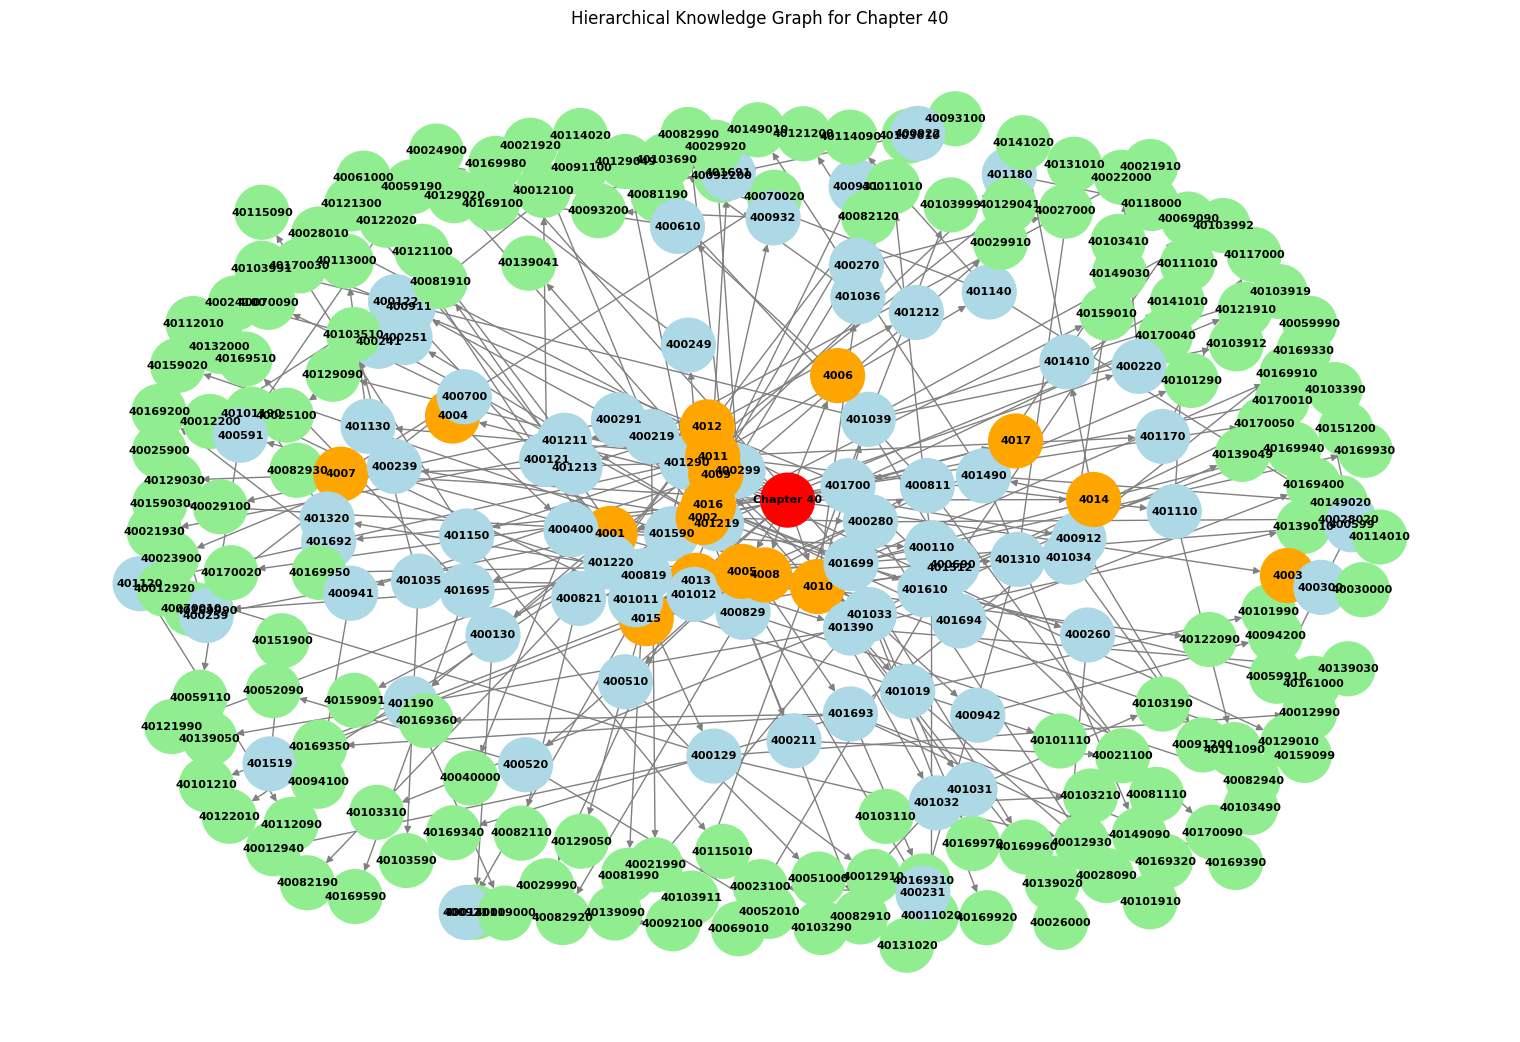

In [6]:
def visualize_chapter_subgraph(kg_instance, chapter_num):
    """
    Visualizing the entire graph is messy. We visualize a specific Chapter 
    to demonstrate the hierarchy clearly.
    """
    chapter_id = f"Chapter {chapter_num}"
    
    # Extract Subgraph using BFS (Breadth First Search) from the Chapter Node
    if chapter_id not in kg_instance.graph:
        print(f"Chapter {chapter_num} not found in graph.")
        return

    # Get all descendants of the chapter
    descendants = nx.descendants(kg_instance.graph, chapter_id)
    subgraph_nodes = descendants.union({chapter_id})
    subgraph = kg_instance.graph.subgraph(subgraph_nodes)
    
    # 2. Plotting
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(subgraph, k=0.15, iterations=20)
    
    # Color coding nodes
    node_colors = []
    for node in subgraph.nodes():
        node_type = subgraph.nodes[node].get('type')
        if node_type == 'chapter': 
            node_colors.append('red')
        elif node_type == 'heading': 
            node_colors.append('orange')
        elif node_type == 'subheading': 
            node_colors.append('lightblue')
        else: 
            node_colors.append('lightgreen') 

    nx.draw(subgraph, pos, 
            with_labels=True, 
            node_color=node_colors, 
            node_size=1500, 
            font_size=8, 
            font_weight="bold", 
            arrows=True,
            edge_color="gray")
    
    plt.title(f"Hierarchical Knowledge Graph for Chapter {chapter_num}")
    plt.show()

# Visualize Chapter 40 (Rubber) as per assignment sample
visualize_chapter_subgraph(kg, 40)

**Graph Querying**

In [7]:
def get_item_context(kg_instance, item_code):
    """
    Traverses the graph upwards from an Item to the Root to get full context for the direct HSN lookup.
    """
    item_id = str(item_code)
    
    if item_id not in kg_instance.graph:
        return "Item not found in Knowledge Graph."
    
    # Get immediate attributes
    node_attrs = kg_instance.graph.nodes[item_id]
    
    # Traverse predecessors (Parents)
    parents = list(kg_instance.graph.predecessors(item_id))
    
    context = {
        "HSN Code": item_id,
        "Description": node_attrs.get('description'),
        "Policy": node_attrs.get('policy'),
        "Hierarchy Path": []
    }
    
    # Walking up the tree
    curr = item_id
    while True:
        preds = list(kg_instance.graph.predecessors(curr))
        if not preds:
            break
        parent = preds[0]
        parent_desc = kg_instance.graph.nodes[parent].get('description', 'Root')
        context["Hierarchy Path"].append(f"{parent} ({parent_desc})")
        curr = parent
        
    return context

# Test the Query Function
lookup_result = get_item_context(kg, 40011010)
print("Graph Traversal Result for 40011010:")
print(json.dumps(lookup_result, indent=2))

Graph Traversal Result for 40011010:
{
  "HSN Code": "40011010",
  "Description": "Prevulcanised",
  "Policy": "Free",
  "Hierarchy Path": [
    "400110 (Natural rubber latex, whether or not pre- vulcanised)",
    "4001 (Natural rubber, balata, gutta-percha, guayule, chicle and similar natural gums, in primary forms or in plates, sheets or strip.)",
    "Chapter 40 (Rubber And Articles Thereof.)",
    "Trade Policy Schedule-II (Root of Export Policy)"
  ]
}


**Vector Store Setup**

In [9]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
import time
import numpy as np

# API key loading and verification
import os
from dotenv import load_dotenv
load_dotenv()

if not os.getenv("OPENAI_API_KEY"):
    print("WARNING: OPENAI_API_KEY not found. Please set it in your .env file.")

class HSNVectorStore:
    def __init__(self):
        self.embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
        self.vector_db = None
        self.persist_directory = "data/chroma_hsn_db"

    def prepare_documents(self, structured_data: List[Dict]) -> List[Document]:
        """
        Converts structured JSON into Semantic Documents.
        Crucial Step: 'Semantic Serialization' - flattening hierarchy into a single string.
        """
        documents = []
        print("Preparing documents for embedding...")
        
        for entry in structured_data:
            # 1. Construct Semantic Content
            # We combine the hierarchy into a natural language description
            content = (
                f"HSN Code: {entry['HSN Code']}. "
                f"Product Category: {entry['Chapter_Description']} > {entry['Heading_Description']}. "
                f"Specific Product: {entry['Subheading_Description']} - {entry['Description']}. "
                f"Export Policy: {entry['FinalHSN']}."
            )
            
            # 2. Metadata for filtering and reference
            meta = {
                "hsn_code": entry['HSN Code'],
                "chapter": entry['ChapterNumber'],
                "policy": entry['FinalHSN'],
                "description": entry['Description']
            }
            
            documents.append(Document(page_content=content, metadata=meta))
            
        print(f"Prepared {len(documents)} semantic documents.")
        return documents

    def build_index(self, documents: List[Document]):
        """
        Creates the Vector Store.
        """
        print("Generating Embeddings and building Index (this may take a moment)...")
        self.vector_db = Chroma.from_documents(
            documents=documents,
            embedding=self.embeddings,
            persist_directory=self.persist_directory
        )
        print("Index built and persisted.")

    def search(self, query: str, k: int = 5):
        """
        Performs Similarity Search with Latency Benchmarking.
        """
        if not self.vector_db:
            raise ValueError("Index not built!")
            
        start_time = time.time()
        
        # similarity_search_with_score returns L2 distance (lower is better for Chroma)
        # or Cosine Similarity depending on config. Default Chroma is Distance.
        results = self.vector_db.similarity_search_with_score(query, k=k)
        
        end_time = time.time()
        latency = (end_time - start_time) * 1000 # ms
        
        return results, latency

# Initialize
rag_system = HSNVectorStore()

In [10]:
# Building Index
# Convert the data into Documents
docs = rag_system.prepare_documents(data)

# Building the DB -- though for real apps, we check if DB exists. For assignment, we overwrite/rebuild.
if os.path.exists(rag_system.persist_directory):
    import shutil
    shutil.rmtree(rag_system.persist_directory) # Clean start

rag_system.build_index(docs)

Preparing documents for embedding...
Prepared 1667 semantic documents.
Generating Embeddings and building Index (this may take a moment)...
Index built and persisted.


**Benchmarking & Retrieval Test**

In [11]:
def benchmark_retrieval(query: str):
    print(f"\n--- Benchmarking Query: '{query}' ---")
    
    results, latency = rag_system.search(query, k=3)
    
    print(f"Latency: {latency:.2f} ms")
    print("Top Results:")
    
    for i, (doc, score) in enumerate(results):
        # Relevance Ranking Logic
        # Chroma score is distance: 0 is perfect match, > 1 is unrelated
        # We convert distance to a 'Relevance Confidence' percentage roughly
        relevance = max(0, (1 - score) * 100) 
        
        print(f"{i+1}. HSN: {doc.metadata['hsn_code']} | Relevance: {relevance:.2f}%")
        print(f"   Context: {doc.page_content[:150]}...")

# Test with a semantic query (not exact keywords)
benchmark_retrieval("elastic material for making tires")
benchmark_retrieval("Natural rubber latex")


--- Benchmarking Query: 'elastic material for making tires' ---
Latency: 555.85 ms
Top Results:
1. HSN: 40029920 | Relevance: 0.00%
   Context: HSN Code: 40029920. Product Category: Rubber And Articles Thereof. > Synthetic rubber and factice derived from oils, in primary forms or in plates, sh...
2. HSN: 40115010 | Relevance: 0.00%
   Context: HSN Code: 40115010. Product Category: Rubber And Articles Thereof. > New pneumatic tyres, of rubber.. Specific Product: Of a kind used on bicycles - M...
3. HSN: 40122020 | Relevance: 0.00%
   Context: HSN Code: 40122020. Product Category: Rubber And Articles Thereof. > Retreaded or used pneumatic tyres of rubber; solid or cushion tyres, tyre treads ...

--- Benchmarking Query: 'Natural rubber latex' ---
Latency: 467.74 ms
Top Results:
1. HSN: 40011010 | Relevance: 20.88%
   Context: HSN Code: 40011010. Product Category: Rubber And Articles Thereof. > Natural rubber, balata, gutta-percha, guayule, chicle and similar natural gums, i...
2. HSN: 40

**Query Processing**

In [12]:
from collections import Counter

class HSNClassifier:
    def __init__(self, vector_store, knowledge_graph):
        self.rag = vector_store
        self.kg = knowledge_graph

    def identify_intent(self, query: str, results: List[tuple]) -> str:
        """
        First Principles Logic to determine what the user wants based on 
        query pattern and vector search result distribution.
        """
        # Direct Code Lookup (Regex)
        # Matches 4, 6, or 8 digit numbers
        if re.search(r"\b\d{4,8}\b", query):
            return "DIRECT_LOOKUP"

        # Analyze Vector Scores (Distance)
        # Chroma returns distance (lower is better). 
        # Let's convert to similarity (0 to 1) for easier logic.
        scores = [1 - r[1] for r in results] 
        top_score = scores[0]
        
        # Broad Category Detection
        # If the user asks "Rubber products", the top results might be specific items
        # but they will all belong to Chapter 40.
        # Logic: If query is short and top results share the same Chapter but differ in Headings.
        chapters = [r[0].metadata['chapter'] for r in results]
        chapter_consensus = Counter(chapters).most_common(1)[0][1] # Count of most common chapter
        
        if "classification" in query.lower() or "chapter" in query.lower():
            return "BROAD_CATEGORY"

        # Disambiguation Detection
        # If top 2 results have very similar scores (e.g., diff < 0.02)
        if len(scores) > 1 and (scores[0] - scores[1] < 0.02):
            return "AMBIGUOUS"

        # Default
        return "SPECIFIC_PRODUCT"

    def classify(self, query: str):
        print(f"\n🔹 Processing Query: '{query}'")
        
        # Step 1: Check for Direct Code first (Bypass Vector Search)
        code_match = re.search(r"\b\d{8}\b", query)
        if code_match:
            print("   ↳ Intent Detected: DIRECT_LOOKUP (Regex Match)")
            return self._handle_direct_lookup(code_match.group())

        # Step 2: Vector Search
        results, _ = self.rag.search(query, k=5)
        
        # Step 3: Determine Intent based on results
        intent = self.identify_intent(query, results)
        print(f"   ↳ Intent Detected: {intent}")

        # Step 4: Execute Strategy
        if intent == "DIRECT_LOOKUP":
            # Fallback if regex missed it but vector search found a code in text
            return self._handle_direct_lookup(query)
            
        elif intent == "BROAD_CATEGORY":
            return self._handle_broad_query(results)
            
        elif intent == "AMBIGUOUS":
            return self._handle_ambiguous_query(results)
            
        else:
            return self._handle_specific_query(results)

    # --- HANDLERS ---

    def _handle_direct_lookup(self, code):
        """Test Case 5 Logic"""
        # Use the Knowledge Graph for O(1) lookup
        context = get_item_context(self.kg, code) 
        if isinstance(context, str):
            return f"Error: {context}"
        
        return {
            "Type": "Direct Lookup",
            "HSN Code": context['HSN Code'],
            "Description": context['Description'],
            "Policy": context['Policy'],
            "Hierarchy": " -> ".join(context['Hierarchy Path'][::-1])
        }

    def _handle_broad_query(self, results):
        """Test Case 3 Logic"""
        # Extract the common Chapter
        top_doc = results[0][0]
        chapter_desc = top_doc.page_content.split("Product Category: ")[1].split(" >")[0]
        
        return {
            "Type": "Broad Category",
            "Message": f"This query relates to {chapter_desc}.",
            "Suggestion": "Please specify the product type (e.g., 'Latex', 'Tires') for a specific HSN code."
        }

    def _handle_ambiguous_query(self, results):
        """Test Case 4 Logic"""
        options = []
        for doc, score in results[:3]: # Take top 3
            options.append({
                "HSN Code": doc.metadata['hsn_code'],
                "Description": doc.metadata['description'],
                "Policy": doc.metadata['policy']
            })
        
        return {
            "Type": "Disambiguation Required",
            "Message": "Multiple similar products found. Please clarify:",
            "Options": options
        }

    def _handle_specific_query(self, results):
        """Test Case 1 & 2 Logic"""
        top_doc = results[0][0]
        return {
            "Type": "Specific Match",
            "HSN Code": top_doc.metadata['hsn_code'],
            "Description": top_doc.metadata['description'],
            "Policy": top_doc.metadata['policy'],
            "Confidence": f"{(1 - results[0][1]):.4f}" # Similarity score
        }

# Initialize Classifier
classifier = HSNClassifier(rag_system, kg)

**Executing test cases**

In [13]:
def run_test_case(case_id, query):
    print(f"\n{'='*20} {case_id} {'='*20}")
    result = classifier.classify(query)
    print(json.dumps(result, indent=2))

# 1. Test Case 1: Direct Product Query
run_test_case("TEST CASE 1", "What is the HSN code for natural rubber latex?")

# 2. Test Case 2: Specific Product Type
run_test_case("TEST CASE 2", "HSN code for prevulcanised rubber")

# 3. Test Case 3: Broad Category Query
run_test_case("TEST CASE 3", "Rubber products classification")

# 4. Test Case 4: Similar Products Disambiguation
# Note: "Natural rubber latex" might trigger specific or ambiguous depending on embedding distance.
# Let's try a query known to be split in the table.
run_test_case("TEST CASE 4", "Natural rubber latex") 

# 5. Test Case 5: Direct HSN Lookup
run_test_case("TEST CASE 5", "Tell me about HSN 40011010")


==================== TEST CASE 1 ====================

🔹 Processing Query: 'What is the HSN code for natural rubber latex?'
   ↳ Intent Detected: SPECIFIC_PRODUCT
{
  "Type": "Specific Match",
  "HSN Code": 40012200,
  "Description": "Natural rubber in other forms : -- Technically specified natural rubber (TSNR)",
  "Policy": "Free",
  "Confidence": "0.5245"
}

==================== TEST CASE 2 ====================

🔹 Processing Query: 'HSN code for prevulcanised rubber'
   ↳ Intent Detected: AMBIGUOUS
{
  "Type": "Disambiguation Required",
  "Message": "Multiple similar products found. Please clarify:",
  "Options": [
    {
      "HSN Code": 40059990,
      "Description": "Other",
      "Policy": "Free"
    },
    {
      "HSN Code": 40161000,
      "Description": "Of cellular rubber",
      "Policy": "Free"
    },
    {
      "HSN Code": 40052090,
      "Description": "Other",
      "Policy": "Free"
    }
  ]
}

==================== TEST CASE 3 ====================

🔹 Processing Quer